# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [ ]:
# when running in colab, un-comment this
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


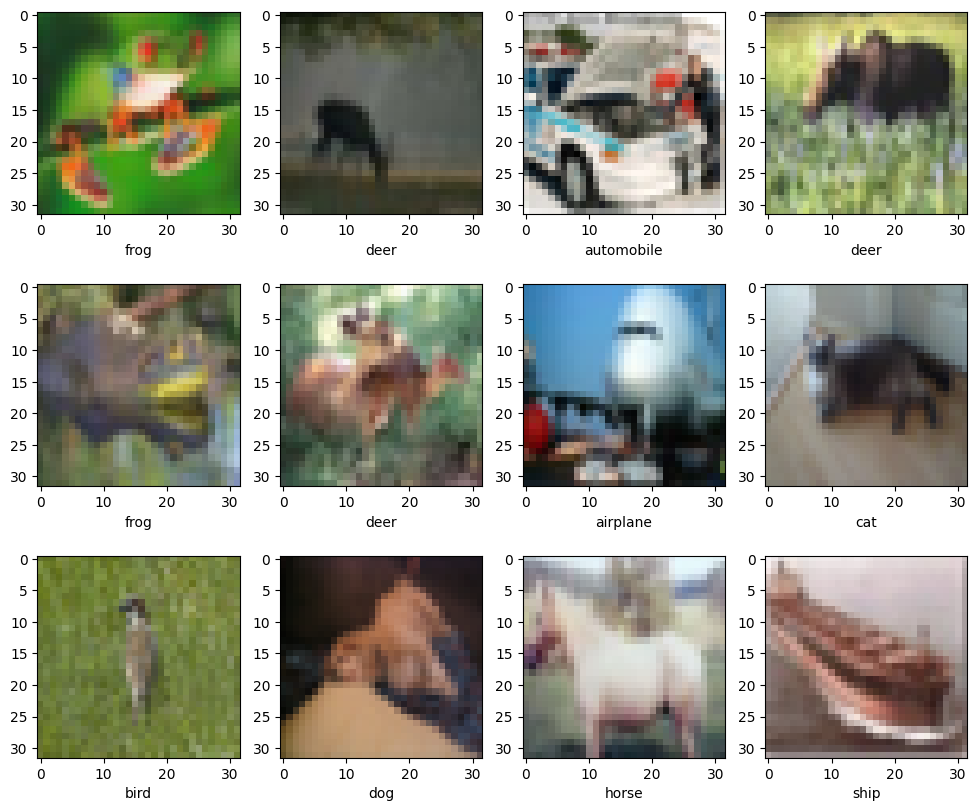

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [224]:
import torch, torch.nn as nn
import torch.nn.functional as F
device = "mps" if torch.mps.is_available() else "cpu"

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    

device

'mps'

Let's start with a dense network for our baseline:

In [37]:
model = nn.Sequential().to(device)

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

model.to(device)

Sequential(
  (flatten): Flatten()
  (dense1): Linear(in_features=3072, out_features=64, bias=True)
  (dense1_relu): ReLU()
  (dense2_logits): Linear(in_features=64, out_features=10, bias=True)
)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [38]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [39]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2841, device='mps:0', grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [40]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [41]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [43]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.cpu().max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.030s
  training loss (in-iteration): 	1.853345
  validation accuracy: 			36.91 %
Epoch 2 of 100 took 1.011s
  training loss (in-iteration): 	1.789845
  validation accuracy: 			38.64 %
Epoch 3 of 100 took 0.990s
  training loss (in-iteration): 	1.741989
  validation accuracy: 			40.27 %
Epoch 4 of 100 took 0.980s
  training loss (in-iteration): 	1.700009
  validation accuracy: 			39.00 %
Epoch 5 of 100 took 0.996s
  training loss (in-iteration): 	1.664289
  validation accuracy: 			42.45 %
Epoch 6 of 100 took 0.999s
  training loss (in-iteration): 	1.635364
  validation accuracy: 			43.63 %
Epoch 7 of 100 took 1.001s
  training loss (in-iteration): 	1.610245
  validation accuracy: 			40.98 %
Epoch 8 of 100 took 0.993s
  training loss (in-iteration): 	1.587989
  validation accuracy: 			44.35 %
Epoch 9 of 100 took 0.993s
  training loss (in-iteration): 	1.567487
  validation accuracy: 			44.91 %
Epoch 10 of 100 took 0.990s
  training loss (in-iteration): 	1.552342
  v



### Final test

In [44]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.cpu().max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		50.12 %
Achievement unlocked: 60lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [174]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

from IPython.display import clear_output
import os

device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [77]:
models = []

SmallConvNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
).to(device)

models.append(SmallConvNet)

In [201]:
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=200, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=200)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=200)

In [60]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(history["acc"]["train"][-1] * 100)
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(history["acc"]["val"][-1] * 100)
    )

In [61]:
def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)

In [216]:
def get_batch_loss(X_batch, y_batch, model, criterion, current_loss, current_acc):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc

In [110]:
def train(model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=30, save_dir=None):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :param save_dir: в какую папку в текущей директории сохранять весы
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, train_loss, train_acc, len(train_batch_gen), "train")

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

        if save_dir is not None:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            }, os.path.join(save_dir, f'epoch_{epoch}.pth'))

    return history

In [59]:
def plot_histories(histories, title=None, names=None):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    plt.suptitle(title)
    
    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--")
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--")
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()

small_conv_history = []

optimizer = torch.optim.Adam(SmallConvNet.parameters())
small_conv_history.append(
    train(
        SmallConvNet,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs=30,
    )
)

torch.save(SmallConvNet.state_dict(), "weights_small_conv_net.pth")

Epoch 30 of 30 took 1.021 s
  training loss: 	0.844517
  validation loss: 	1.111990
  training accuracy: 			69.93 %
  validation accuracy: 			62.56 %


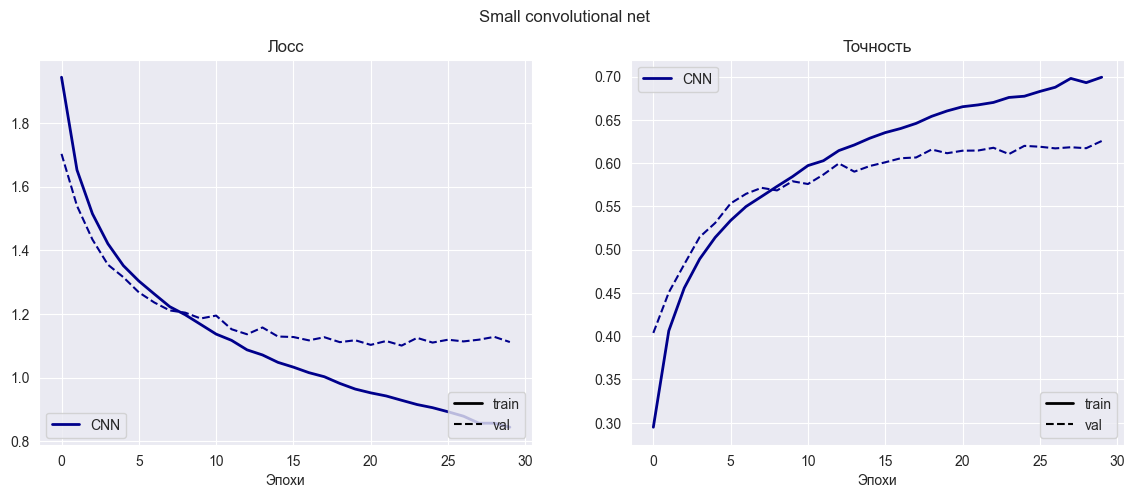

In [80]:
plot_histories(small_conv_history, "Small convolutional net", ["CNN"])

In [95]:
logits = SmallConvNet(torch.tensor(X_test).to(device))
loss = criterion(logits, torch.tensor(y_test).long().to(device)).cpu().detach().numpy()

y_pred = logits.max(1)[1].detach().cpu().numpy()
acc = np.mean(y_test == y_pred)
print(loss, acc)

1.1107955 0.6201


In [94]:
test_loss, _, test_acc = get_batch_loss(torch.tensor(X_test), torch.tensor(y_test), SmallConvNet, criterion, 0, 0)
print("Test loss:       ", np.round(test_loss.cpu().data.item(), 2))
print("Test acccuracy:  ", np.round(test_acc, 2))

Test loss:        1.11
Test acccuracy:   0.62


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [112]:
ConvNetWithNorm = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(num_features=10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
).to(device)

In [113]:
conv_with_norm_history = []

optimizer = torch.optim.Adam(ConvNetWithNorm.parameters(), lr=0.0003)
conv_with_norm_history.append(
    train(
        ConvNetWithNorm,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs=30,
        save_dir='norm_weights'
    )
)


Epoch 30 of 30 took 1.230 s
  training loss: 	0.466719
  validation loss: 	1.144958
  training accuracy: 			84.22 %
  validation accuracy: 			64.17 %


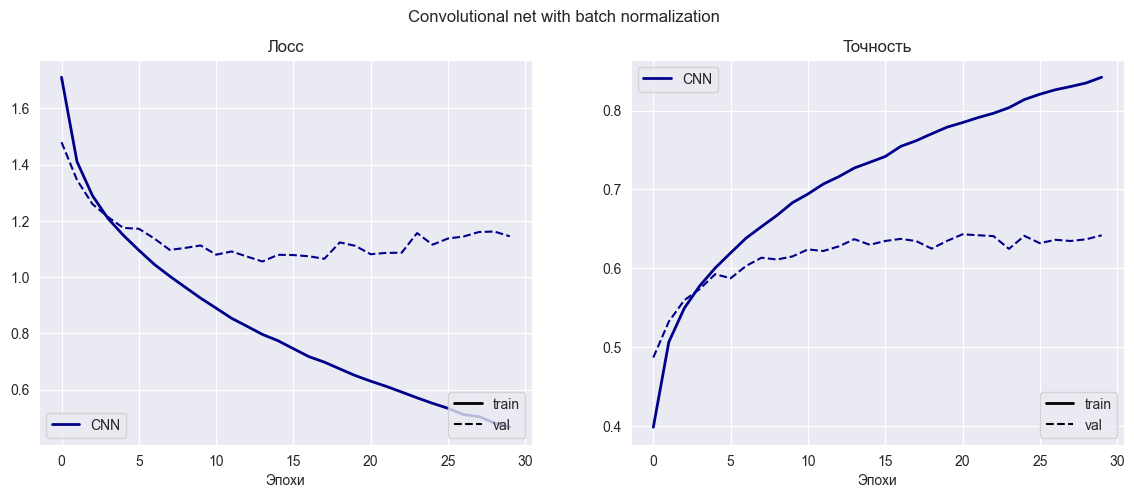

In [114]:
plot_histories(conv_with_norm_history, "Convolutional net with batch normalization", ["CNN"])

In [115]:
test_loss, _, test_acc = get_batch_loss(torch.tensor(X_test), torch.tensor(y_test), ConvNetWithNorm, criterion, 0, 0)
print("Test loss:       ", np.round(test_loss.cpu().data.item(), 2))
print("Test acccuracy:  ", np.round(test_acc, 2))

Test loss:        1.18
Test acccuracy:   0.63



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [175]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [231]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

In [232]:
# from torchvision.datasets import CIFAR10
# dataset = CIFAR10("./cifar_data/", train=True)
# test_dataset = CIFAR10("./cifar_data/", train=False, transform=transform_test)

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_indices, val_indices = random_split(range(len(dataset)), [train_size, val_size])

# train_dataset = Subset(dataset, train_indices)
# train_dataset.dataset.transform = transform_augment
# val_dataset = Subset(dataset, val_indices)
# val_dataset.dataset.transform = transform_test

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=64)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=64)


In [233]:
ConvNetWithAugm = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(num_features=10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
).to(device)

In [234]:
conv_with_augm_history = []

optimizer = torch.optim.Adam(ConvNetWithAugm.parameters(), lr=0.0003)
conv_with_augm_history.append(
    train(
        ConvNetWithAugm,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs=30,
        save_dir='augm_weights'
    )
)

Epoch 30 of 30 took 2.594 s
  training loss: 	0.450568
  validation loss: 	1.364877
  training accuracy: 			84.09 %
  validation accuracy: 			61.75 %


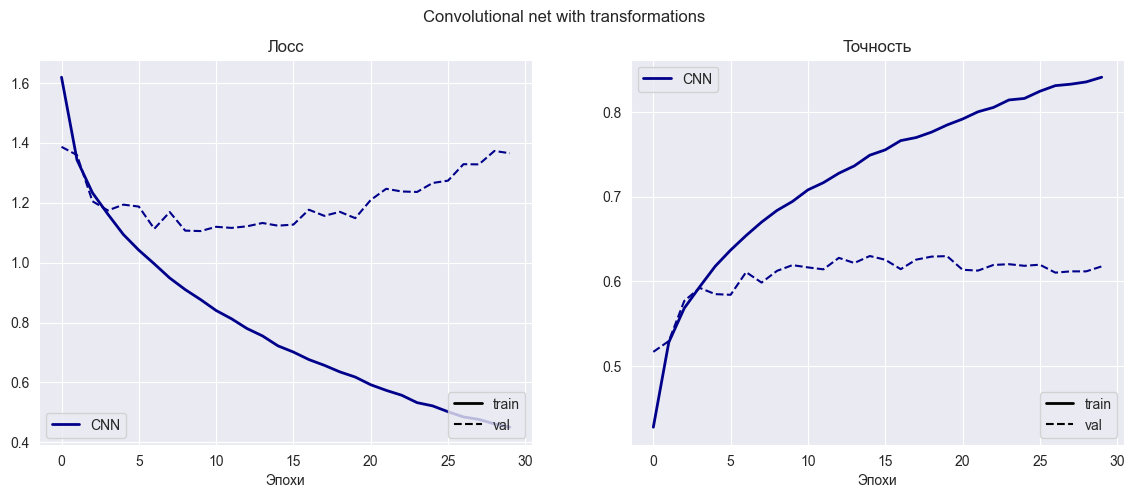

In [235]:
plot_histories(conv_with_augm_history, "Convolutional net with transformations", ["CNN"])

When testing, we don't need random crops, just normalize with same statistics.

In [236]:
_, test_loss, test_acc = get_batch_loss(torch.tensor(X_test), torch.tensor(y_test), ConvNetWithAugm, criterion, 0, 0)
print("Test loss:       ", np.round(test_loss, 2))
print("Test acccuracy:  ", np.round(test_acc, 2))

Test loss:        1.35
Test acccuracy:   0.62


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [ ]:
# you might as well write your solution here :)